First, import needed modules

In [796]:
import numpy as np
import pandas as pd
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely.speedups
from shapely.ops import unary_union

Initalize variables

In [797]:
shapely.speedups.enable()
path = os.getcwd()
print(path)

/Users/jan/Dropbox/UP_EPQM/2222/MA/powerlinemonsters


Load shapefile with municipality and state boundaries and plot it for inspection

<AxesSubplot:>

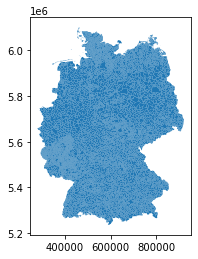

In [798]:
municipalities = gpd.read_file(f'{path}/data/geodata/VG250_GEM.shp')
municipalities.index.rename('ID', inplace=True)
states = gpd.read_file(f'{path}/data/geodata/VG250_LAN.shp')
municipalities.plot()

Inspect the dataframe: GEN has the municipalities' names, geometry are the polygons.


In [799]:
municipalities.head()

,ADE,GF,BSG,RS,AGS,SDV_RS,GEN,BEZ,IBZ,BEM,...,SN_V2,SN_G,FK_S3,NUTS,RS_0,AGS_0,WSK,EWZ,DEBKG_ID,geometry
ID,,,,,,,,,,,,,,,,,,,,,
0,6,2,1,083355004002,08335002,083355004002,Allensbach,Gemeinde,64,gemeinschaftsangehörig,...,04,002,R,DE138,083355004002,08335002,2009-01-01,0,DEBKGDL20000HKND,"POLYGON ((507883.567 5282624.777, 507923.277 5..."
1,6,2,1,083355004066,08335066,083355004066,Reichenau,Gemeinde,64,gemeinschaftsangehörig,...,04,066,R,DE138,083355004066,08335066,2009-01-01,0,DEBKGDL20000HKNF,"MULTIPOLYGON (((508095.875 5281959.799, 508134..."
2,6,2,1,083350063063,08335063,083350063063,Radolfzell am Bodensee,Stadt,61,None,...,63,063,R,DE138,083350063063,08335063,2009-01-01,0,DEBKGDL20000HKNE,"POLYGON ((500719.668 5285290.972, 500632.566 5..."
3,6,2,1,010595990186,01059186,010595990186,Steinbergkirche,Gemeinde,64,gemeinschaftsangehörig,...,90,186,R,DEF0C,010595990186,01059186,2013-03-01,0,DEBKGDL20000XYFA,"POLYGON ((547082.162 6075557.922, 547528.602 6..."
4,6,2,1,033595407018,03359018,033595407018,Freiburg (Elbe),Gemeinde,64,gemeinschaftsangehörig,...,07,018,K,DE939,033595407018,03359018,2009-01-01,0,DEBKGDL20000QMG4,"POLYGON ((517934.141 5968832.380, 519053.640 5..."


Check for duplicates in terms of the AGS (Amtlicher Gemeindeschlüssel) -> there are duplicates.

In [800]:
municipalities['ags_dup'] = municipalities.duplicated(subset=['AGS'], keep=False)
municipalities.head()

,ADE,GF,BSG,RS,AGS,SDV_RS,GEN,BEZ,IBZ,BEM,...,SN_G,FK_S3,NUTS,RS_0,AGS_0,WSK,EWZ,DEBKG_ID,geometry,ags_dup
ID,,,,,,,,,,,,,,,,,,,,,
0,6,2,1,083355004002,08335002,083355004002,Allensbach,Gemeinde,64,gemeinschaftsangehörig,...,002,R,DE138,083355004002,08335002,2009-01-01,0,DEBKGDL20000HKND,"POLYGON ((507883.567 5282624.777, 507923.277 5...",True
1,6,2,1,083355004066,08335066,083355004066,Reichenau,Gemeinde,64,gemeinschaftsangehörig,...,066,R,DE138,083355004066,08335066,2009-01-01,0,DEBKGDL20000HKNF,"MULTIPOLYGON (((508095.875 5281959.799, 508134...",True
2,6,2,1,083350063063,08335063,083350063063,Radolfzell am Bodensee,Stadt,61,None,...,063,R,DE138,083350063063,08335063,2009-01-01,0,DEBKGDL20000HKNE,"POLYGON ((500719.668 5285290.972, 500632.566 5...",True
3,6,2,1,010595990186,01059186,010595990186,Steinbergkirche,Gemeinde,64,gemeinschaftsangehörig,...,186,R,DEF0C,010595990186,01059186,2013-03-01,0,DEBKGDL20000XYFA,"POLYGON ((547082.162 6075557.922, 547528.602 6...",True
4,6,2,1,033595407018,03359018,033595407018,Freiburg (Elbe),Gemeinde,64,gemeinschaftsangehörig,...,018,K,DE939,033595407018,03359018,2009-01-01,0,DEBKGDL20000QMG4,"POLYGON ((517934.141 5968832.380, 519053.640 5...",True


Merge shapes for the duplicate municipalities

In [801]:
duplicates = municipalities[municipalities['ags_dup'] == True] # create duplicates df
duplicates.insert(loc=len(duplicates.columns), column='union', value=0) # insert a new 'union column
duplicates.sort_values(by=['GEN'], inplace=True) # sort by city name
for i in range(0, len(duplicates), 2): # iterate over all duplicate cities
    city_name = duplicates.iloc[i, 6] # get the city name
    duplicate = duplicates[duplicates['GEN'] == city_name] # get geometries of both polygons for a given city
    duplicates['union'].loc[duplicates.index[i]]  = duplicate.unary_union # combine the shapes
duplicates = duplicates[duplicates['union'] != 0 ] # drop the duplicates, keep only the combined shapes
duplicates = duplicates.drop(columns=['geometry']) # drop the geometry column
duplicates.rename(columns = {'union':'geometry'}, inplace = True)   #rename the union column to geometry
duplicates.head()

/var/folders/wm/mtrphj0s0msgrmyshf3hgk740000gn/T/ipykernel_25097/658540410.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duplicates.sort_values(by=['GEN'], inplace=True) # sort by city name
/var/folders/wm/mtrphj0s0msgrmyshf3hgk740000gn/T/ipykernel_25097/658540410.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duplicates['union'].loc[duplicates.index[i]]  = duplicate.unary_union # combine the shapes
/var/folders/wm/mtrphj0s0msgrmyshf3hgk740000gn/T/ipykernel_25097/658540410.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: h

,ADE,GF,BSG,RS,AGS,SDV_RS,GEN,BEZ,IBZ,BEM,...,SN_G,FK_S3,NUTS,RS_0,AGS_0,WSK,EWZ,DEBKG_ID,ags_dup,geometry
ID,,,,,,,,,,,,,,,,,,,,,
0,6,2,1,083355004002,08335002,083355004002,Allensbach,Gemeinde,64,gemeinschaftsangehörig,...,002,R,DE138,083355004002,08335002,2009-01-01,0,DEBKGDL20000HKND,True,"POLYGON ((507734.802 5282705.817, 507668.952 5..."
9514,6,4,1,010585893004,01058004,010585893004,Altenhof,Gemeinde,64,gemeinschaftsangehörig,...,004,R,DEF0B,010585893004,01058004,2008-01-01,306,DEBKGDL20000E4SF,True,"POLYGON ((561050.117 6035217.336, 560590.497 6..."
76,6,2,1,130755552003,13075003,130755552003,Altwarp,Gemeinde,64,gemeinschaftsangehörig,...,003,R,DE80I,130755552003,13075003,2011-09-04,0,DEBKGDL20000001U,True,"POLYGON ((845006.443 5964574.720, 844395.951 5..."
9247,6,4,1,130750005005,13075005,130750005005,Anklam,Stadt,61,None,...,005,R,DE80F,130750005005,13075005,2011-09-04,12797,DEBKGDL20000004B,True,"POLYGON ((813991.774 5979789.430, 813943.203 5..."
69,6,2,1,010595920002,01059002,010595920002,Arnis,Stadt,63,gemeinschaftsangehörig,...,002,R,DEF0C,010595920002,01059002,None,0,DEBKGDL20000E5UJ,True,"POLYGON ((560223.896 6053624.067, 560024.356 6..."


Concatenate the duplicates df with the combined shapes to the municipalities df

In [802]:
municipalities = municipalities[municipalities['ags_dup'] == False]
municipalities = gpd.GeoDataFrame(pd.concat([municipalities, duplicates], ignore_index=True), crs=[municipalities, duplicates][0].crs)
municipalities.sort_values(by=['GEN'], inplace=True) # sort by city name
municipalities = municipalities.drop(columns=['ags_dup'])
municipalities.to_csv(f'{path}/data/treatment.csv', encoding = 'utf-8-sig')
municipalities.head()

,ADE,GF,BSG,RS,AGS,SDV_RS,GEN,BEZ,IBZ,BEM,...,SN_V2,SN_G,FK_S3,NUTS,RS_0,AGS_0,WSK,EWZ,DEBKG_ID,geometry
6174,6,4,1,072355007001,07235001,072355007001,Aach,Gemeinde,64,gemeinschaftsangehörig,...,07,001,K,DEB25,072355007001,07235001,2009-01-01,1058,DEBKGDL20000E4CM,"POLYGON ((327525.294 5518625.943, 327584.389 5..."
1364,6,4,1,083355001001,08335001,083355001001,Aach,Stadt,63,gemeinschaftsangehörig,...,01,001,R,DE138,083355001001,08335001,2009-01-01,2161,DEBKGDL20000E67B,"POLYGON ((487360.997 5299527.761, 487650.058 5..."
10935,6,4,1,053340002002,05334002,053340002002,Aachen,Stadt,61,None,...,02,002,R,DEA2D,053340002002,05334002,2009-10-21,241683,DEBKGDL20000E2NA,"MULTIPOLYGON (((292845.650 5637601.948, 292858..."
1243,6,4,1,081365001088,08136088,081365001088,Aalen,Stadt,63,gemeinschaftsangehörig,...,01,088,R,DE11D,081365001088,08136088,2009-01-01,66813,DEBKGDL20000DYJC,"POLYGON ((577663.442 5416758.805, 577602.864 5..."
5876,6,4,1,064390001001,06439001,064390001001,Aarbergen,Gemeinde,62,None,...,01,001,R,DE71D,064390001001,06439001,2009-01-01,5949,DEBKGDL20000E19C,"POLYGON ((439013.740 5570142.616, 438926.143 5..."


The data use the European Terrestrial Reference System 1989 as coordinate reference system (CRS), units are metres

In [803]:
municipalities.crs

<Derived Projected CRS: EPSG:25832>
Name: ETRS89 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 6°E and 12°E: Austria; Belgium; Denmark - onshore and offshore; Germany - onshore and offshore; Norway including - onshore and offshore; Spain - offshore.
- bounds: (6.0, 38.76, 12.0, 84.33)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Load shapefile with power lines and plot it for inspection, as the CRS of powerlines is EPSG 4326 (Degrees), convert to EPSG 25832 (Meters)

In [804]:
powerlines = gpd.read_file(f'{path}/data/geodata/powerlines.shp')
powerlines = powerlines.to_crs(epsg=25832)
powerlines.head()

,#BBPlG2013,Start,End,New,Retro,geometry
0,None,Emden-Borssum,Osterath,NaN,NaN,"LINESTRING (381802.135 5912655.617, 334024.420..."
1,None,Osterath,Philippsburg,NaN,NaN,"LINESTRING (334024.420 5682438.683, 460302.514..."
2,None,Brunsbüttel,Großgartach,1.0,NaN,"LINESTRING (509169.440 5972099.313, 509180.155..."
3,None,Wilster,Grafenrheinfeld,1.0,NaN,"LINESTRING (524519.730 5975050.664, 585751.695..."
4,None,Bad Lauchstädt,Meitingen,1.0,NaN,"LINESTRING (699592.896 5696894.010, 636525.563..."


Check CRS conversion

In [805]:
powerlines.crs

<Derived Projected CRS: EPSG:25832>
Name: ETRS89 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 6°E and 12°E: Austria; Belgium; Denmark - onshore and offshore; Germany - onshore and offshore; Norway including - onshore and offshore; Spain - offshore.
- bounds: (6.0, 38.76, 12.0, 84.33)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Plot for inspection

<AxesSubplot:>

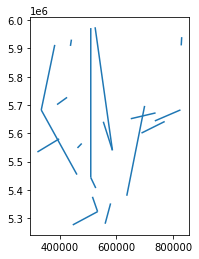

In [806]:
powerlines.plot()

Combine municipalities and powerlines in a plot

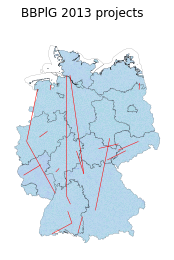

In [807]:
powerlines.set_geometry('geometry')
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_axis_off()
municipalities.plot(ax=ax, color='lightblue', edgecolor='blue', lw=0.01, zorder=1)
states.boundary.plot(ax=ax, color='black', lw = 0.1, zorder=2)
powerlines.plot(ax=ax, color='red', lw=0.5, zorder=3)
plt.suptitle('BBPlG 2013 projects')
plt.savefig(f'{path}/figures/BBPLG2013_projects.png', dpi=600)


Now construct the treatment indicator by checking if any of the power lines *directly* intersect with municipality polygons

In [808]:
municipalities.insert(loc=len(municipalities.columns), column='treated_0', value=0)
for i in range(len(municipalities)):
    municipalities['treated_0'].loc[municipalities.index[i]] = any(powerlines['geometry'].intersects(municipalities['geometry'].values[i]))

/var/folders/wm/mtrphj0s0msgrmyshf3hgk740000gn/T/ipykernel_25097/430223065.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  municipalities['treated_0'].loc[municipalities.index[i]] = any(powerlines['geometry'].intersects(municipalities['geometry'].values[i]))


Plot the municipalities that directly intersect with a powerline

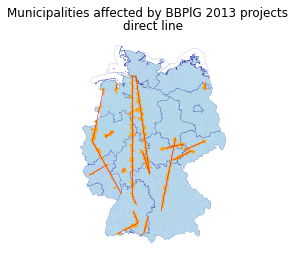

In [809]:
powerlines.set_geometry('geometry')
municipalities_intersected = municipalities[municipalities['treated_0'] == True] #drops all untreated munipalities
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_axis_off()
municipalities.plot(ax=ax, color='lightblue', edgecolor='blue', lw=0.01, zorder=1)
states.boundary.plot(ax=ax, color='darkblue', lw = 0.1, zorder=2)
municipalities_intersected.plot(ax=ax, color='orange', edgecolor='darkorange', lw=0.01, zorder=3)
powerlines.plot(ax=ax, color='red', lw=0.5, zorder=4)
plt.suptitle('Municipalities affected by BBPlG 2013 projects')
plt.title('direct line')
plt.savefig(f'{path}/figures/BBPLG2013_treated_0.png', dpi=600)


Create buffers around the straight lines to create treatment indicator for different corridor widths

In [810]:
for buffer in (5, 10, 15, 25, 50):
    try:
        powerlines.insert(loc=len(powerlines.columns), column=f'geometry_{buffer*2}', value=0) #buffer is added on both sides -> x2 to simplify
    except Exception:
        pass
    powerlines[f'geometry_{buffer*2}'] = powerlines['geometry'].buffer(buffer*1000)
powerlines.head()

,#BBPlG2013,Start,End,New,Retro,geometry,geometry_10,geometry_20,geometry_30,geometry_50,geometry_100
0,None,Emden-Borssum,Osterath,NaN,NaN,"LINESTRING (381802.135 5912655.617, 334024.420...","POLYGON ((338920.102 5681422.665, 338796.941 5...","POLYGON ((343815.785 5680406.647, 343569.462 5...","POLYGON ((348711.467 5679390.629, 348341.984 5...","POLYGON ((358502.833 5677358.593, 357887.026 5...","POLYGON ((382981.245 5672278.504, 381749.633 5..."
1,None,Osterath,Philippsburg,NaN,NaN,"LINESTRING (334024.420 5682438.683, 460302.514...","POLYGON ((464678.801 5456336.019, 464894.761 5...","POLYGON ((469055.088 5458754.306, 469487.009 5...","POLYGON ((473431.375 5461172.593, 474079.257 5...","POLYGON ((482183.949 5466009.166, 483263.752 5...","POLYGON ((504065.385 5478100.600, 506224.990 5..."
2,None,Brunsbüttel,Großgartach,1.0,NaN,"LINESTRING (509169.440 5972099.313, 509180.155...","POLYGON ((514180.155 5443309.268, 514156.089 5...","POLYGON ((519180.155 5443309.369, 519132.023 5...","POLYGON ((524180.155 5443309.470, 524107.956 5...","POLYGON ((534180.155 5443309.673, 534059.823 5...","POLYGON ((559180.155 5443310.180, 558939.491 5..."
3,None,Wilster,Grafenrheinfeld,1.0,NaN,"LINESTRING (524519.730 5975050.664, 585751.695...","POLYGON ((590702.910 5540628.600, 590747.363 5...","POLYGON ((595654.125 5541325.358, 595743.030 5...","POLYGON ((600605.340 5542022.116, 600738.698 5...","POLYGON ((610507.769 5543415.632, 610730.033 5...","POLYGON ((635263.843 5546899.423, 635708.371 5..."
4,None,Bad Lauchstädt,Meitingen,1.0,NaN,"LINESTRING (699592.896 5696894.010, 636525.563...","POLYGON ((641429.928 5378112.459, 641310.917 5...","POLYGON ((646334.293 5377139.214, 646096.272 5...","POLYGON ((651238.658 5376165.970, 650881.626 5...","POLYGON ((661047.387 5374219.481, 660452.335 5...","POLYGON ((685569.212 5369353.258, 684379.107 5..."


Now generate treatment indicators for all buffer sizes

In [811]:
for buffer in (5, 10, 15, 25, 50):
    try:
        municipalities.insert(loc=len(municipalities.columns), column=f'treated_{buffer*2}', value=0)
    except Exception:
        pass
    for i in range(len(municipalities)):
        municipalities[f'treated_{buffer*2}'].loc[municipalities.index[i]] = any(powerlines[f'geometry_{buffer*2}'].intersects(municipalities['geometry'].values[i]))
municipalities.head()

/var/folders/wm/mtrphj0s0msgrmyshf3hgk740000gn/T/ipykernel_25097/690248357.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  municipalities[f'treated_{buffer*2}'].loc[municipalities.index[i]] = any(powerlines[f'geometry_{buffer*2}'].intersects(municipalities['geometry'].values[i]))
/var/folders/wm/mtrphj0s0msgrmyshf3hgk740000gn/T/ipykernel_25097/690248357.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  municipalities[f'treated_{buffer*2}'].loc[municipalities.index[i]] = any(powerlines[f'geometry_{buffer*2}'].intersects(municipalities['geometry'].values[i]))
/var/folders/wm/mtrphj0s0msgrmyshf3hgk740000gn/T/ipykern

,ADE,GF,BSG,RS,AGS,SDV_RS,GEN,BEZ,IBZ,BEM,...,WSK,EWZ,DEBKG_ID,geometry,treated_0,treated_10,treated_20,treated_30,treated_50,treated_100
6174,6,4,1,072355007001,07235001,072355007001,Aach,Gemeinde,64,gemeinschaftsangehörig,...,2009-01-01,1058,DEBKGDL20000E4CM,"POLYGON ((327525.294 5518625.943, 327584.389 5...",False,False,False,False,True,True
1364,6,4,1,083355001001,08335001,083355001001,Aach,Stadt,63,gemeinschaftsangehörig,...,2009-01-01,2161,DEBKGDL20000E67B,"POLYGON ((487360.997 5299527.761, 487650.058 5...",True,True,True,True,True,True
10935,6,4,1,053340002002,05334002,053340002002,Aachen,Stadt,61,None,...,2009-10-21,241683,DEBKGDL20000E2NA,"MULTIPOLYGON (((292845.650 5637601.948, 292858...",False,False,False,False,False,False
1243,6,4,1,081365001088,08136088,081365001088,Aalen,Stadt,63,gemeinschaftsangehörig,...,2009-01-01,66813,DEBKGDL20000DYJC,"POLYGON ((577663.442 5416758.805, 577602.864 5...",False,False,False,False,False,True
5876,6,4,1,064390001001,06439001,064390001001,Aarbergen,Gemeinde,62,None,...,2009-01-01,5949,DEBKGDL20000E19C,"POLYGON ((439013.740 5570142.616, 438926.143 5...",False,False,False,False,False,True


Plot for inspection

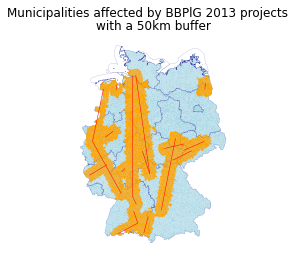

In [812]:
#powerlines.set_geometry('geometry_50')
municipalities_intersected50 = municipalities[municipalities['treated_50'] == True] #drops all untreated munipalities
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_axis_off()
municipalities.plot(ax=ax, color='lightblue', zorder=1)
states.boundary.plot(ax=ax, color='darkblue', lw = 0.1, zorder=2)
municipalities_intersected50.plot(ax=ax, color='orange', edgecolor='darkorange', lw=0.01, zorder=3)
powerlines.plot(ax=ax, color='red', lw=0.5, zorder=4)
plt.suptitle('Municipalities affected by BBPlG 2013 projects')
plt.title('with a 50km buffer')
plt.savefig(f'{path}/figures/BBPLG2013_treated_50.png', dpi=600)


Export treatment dataset from municipalities dataframe

In [813]:
treatment = pd.DataFrame(municipalities)
treatment = treatment.reindex(columns=['AGS', 'GEN', 'treated_0', 'treated_10', 'treated_20', 'treated_30', 'treated_50', 'treated_100'])
treatment = treatment.set_index('AGS')
treatment = treatment.replace({True:1, False:0})
treatment.to_csv(f'{path}/data/treatment.csv', encoding = 'utf-8-sig')
treatment.head()

,GEN,treated_0,treated_10,treated_20,treated_30,treated_50,treated_100
AGS,,,,,,,
07235001,Aach,0,0,0,0,1,1
08335001,Aach,1,1,1,1,1,1
05334002,Aachen,0,0,0,0,0,0
08136088,Aalen,0,0,0,0,0,1
06439001,Aarbergen,0,0,0,0,0,1
